In [225]:
%load_ext autoreload
%autoreload 2

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
# from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# %matplotlib inline 
# %matplotlib notebook

# Directory to save logs and trained model
# MODEL_DIR = os.path.join(ROOT_DIR, "logs")
# sftp://ec2-52-90-145-233.compute-1.amazonaws.com:9122//storage/data/marziehhaghighi/DL_trained_models/mrcnn/logs
# MODEL_DIR ="/storage/data/marziehhaghighi/DL_trained_models/mrcnn/logs"
MODEL_Root_DIR ="/storage/data/marziehhaghighi/DL_trained_models/mrcnn/"

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [226]:
NAME="simul_spots"
# use of pretrained models --> "imagenet","coco","scratch","last"
init_with = "scratch"
# layers to train --> "all" , "heads"
layers_to_tune="heads"

lr=0.001
assign_label_mode ="clustering"#"clustering","classification"

RunName='simul_spots20200812T2042'

fileNumModel='pretrained_'+init_with+'_train_'+layers_to_tune+'_lr_'+str(lr)+'_'+assign_label_mode[0:5];
MODEL_DIR = MODEL_Root_DIR + NAME+'/'+fileNumModel+'/'+RunName
os.listdir(MODEL_DIR)

['mask_rcnn_simul_spots_0019.h5',
 'config.pkl',
 'mask_rcnn_simul_spots_0010.h5',
 'mask_rcnn_simul_spots_0004.h5',
 'mask_rcnn_simul_spots_0013.h5',
 'mask_rcnn_simul_spots_0012.h5',
 'mask_rcnn_simul_spots_0006.h5',
 'mask_rcnn_simul_spots_0005.h5',
 'mask_rcnn_simul_spots_0017.h5',
 'mask_rcnn_simul_spots_0001.h5',
 'mask_rcnn_simul_spots_0008.h5',
 'mask_rcnn_simul_spots_0009.h5',
 'mask_rcnn_simul_spots_0016.h5',
 'events.out.tfevents.1597264980.2d08196bf35f',
 'mask_rcnn_simul_spots_0015.h5',
 'mask_rcnn_simul_spots_0002.h5',
 'mask_rcnn_simul_spots_0007.h5',
 'mask_rcnn_simul_spots_0003.h5',
 'mask_rcnn_simul_spots_0014.h5',
 'csvlog.log',
 'mask_rcnn_simul_spots_0018.h5']

In [24]:
inference_config1.NAME
# MODEL_DIR

'simul_spots'

### Load Config File

In [247]:
# class SpotsConfig(Config):
#     GPU_COUNT = 1
#     IMAGES_PER_GPU = 1
    
import pickle
pkl_file = open(MODEL_DIR+'/config.pkl', 'rb')

inference_config = pickle.load(pkl_file)
inference_config["GPU_COUNT"] = 1
inference_config["IMAGES_PER_GPU"] = 1
inference_config["BATCH_SIZE"] = 1

from collections import namedtuple
inference_config1=namedtuple("infConf", inference_config.keys())(*inference_config.values())

# inference_config.display()

model = modellib.MaskRCNN(mode="inference2", 
                          config=inference_config1,
                          model_dir=MODEL_DIR)

epoch='0019'
model_path = MODEL_DIR+"/mask_rcnn_"+inference_config1.NAME+'_'+epoch+".h5"
# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Tensor("proposal_targets_14/rois:0", shape=(1, ?, 4), dtype=float32) Tensor("proposal_targets_14/target_class_ids:0", shape=(1, ?), dtype=int32) Tensor("proposal_targets_14/target_bbox:0", shape=(1, ?, 4), dtype=float32) Tensor("proposal_targets_14/target_mask:0", shape=(1, ?, 28, 28), dtype=float32)
shared Tensor("pool_squeeze_23/Squeeze_1:0", shape=(?, 160, 512), dtype=float32)
mrcnn_class_logits Tensor("mrcnn_class_logits_23/Reshape_1:0", shape=(?, 160, 5), dtype=float32)
mrcnn_class_logits, mrcnn_class, mrcnn_bbox,shared Tensor("mrcnn_class_logits_23/Reshape_1:0", shape=(?, 160, 5), dtype=float32) Tensor("mrcnn_class_23/Reshape_1:0", shape=(?, 160, 5), dtype=float32) Tensor("mrcnn_bbox_23/Reshape:0", shape=(?, 160, 5, 4), dtype=float32) Tensor("pool_squeeze_23/Squeeze_1:0", shape=(?, 160, 512), dtype=float32)
rpn_rois Tensor("ROI_23/packed_2:0", shape=(1, ?, 4), dtype=float32)
target_class_ids Tensor("proposal_targets_14/target_class_ids:0", shape=(1, ?), dtype=int32)
shared Tensor

In [16]:
ddd.assign_label_mode

'clustering'

In [252]:
class SpotsDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("spots", 1, "A")
        self.add_class("spots", 2, "T")
        self.add_class("spots", 3, "G")
        self.add_class("spots", 4, "C")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
#             print(shapes)
            self.add_image("spots", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, spots=shapes)
            
    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        image=self.add_noise(image)
#         print(info)
#         print(info['spots'])
        for shape, color, dims in info['spots']:            
            image = self.draw_shape(image, "circle", dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "spots":
            return info["spots"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['spots']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['spots']):
#             shape2="circle"
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        shape="circle"
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
#             print("color",color)
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        elif shape == "ellipse":
#             cv2.ellipse(mask, (x, y), (ax, ay), angle, 0, 360, 255, -1)
            cv2.ellipse(image, (x, y), (s,2*s), 45, 0, 360, color, -1)
            
            
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["A", "T", "C", "G"])
#         shape = random.choice(["square", "circle"])
        # Color
#         color = tuple([random.randint(0, 255) for _ in range(3)])
        if shape == "A":
            color=tuple([0,0,255])#blue
        elif shape == "T":
            color=tuple([0,255,0])#green
        elif shape == "C":
            color=tuple([255,0,255])#magneta
        elif shape == "G":
            color=tuple([255,255,0])#yellow

#         print("here",color)
        # Center x, y
        buffer = 10
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
#         s = random.randint(buffer, height//4)
#         print(buffer, int(height//20))
#         s = random.randint(buffer, 20)
        s = random.randint(2, 2)
#         print(s)
        return shape, color, (x, y, s)
    

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
#         bg_color = np.array([random.randint(0, 255) for _ in range(3)])
#         bg_color =np.array([0,0,0])
        bg_color = np.array([random.randint(0, 4) for _ in range(3)])
#         print(bg_color.shape)
#         print(self.add_noise(bg_color))
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(40, 60)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
#         print(shapes)
        return bg_color, shapes
    
    def add_noise(self,image):
    #    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 100
        var = 100
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
    
im_h, im_w= inference_config1.IMAGE_SHAPE[0], inference_config1.IMAGE_SHAPE[1]
# im_h, im_w=512,512

# Training dataset
dataset_train = SpotsDataset()
dataset_train.load_shapes(500, im_h, im_w)
dataset_train.prepare()

# Validation dataset
dataset_val = SpotsDataset()
dataset_val.load_shapes(50, im_h, im_w)
dataset_val.prepare()

original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
image_meta               shape: (17,)                 min:    0.00000  max:  256.00000  int64
gt_class_id              shape: (60,)                 min:    1.00000  max:    4.00000  int32
gt_bbox                  shape: (60, 4)               min:   11.00000  max:  247.00000  int32
gt_mask                  shape: (256, 256, 60)        min:    0.00000  max:    1.00000  bool


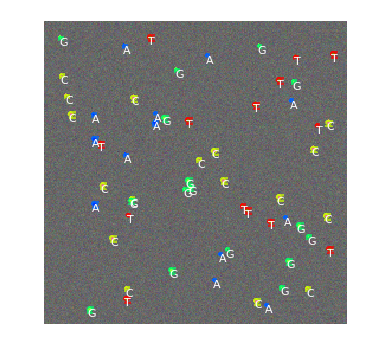

AssertionError: Create model in inference mode.

In [118]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
# image_id=33
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config1, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                             dataset_train.class_names, figsize=(12, 12))

visualize.display_instances2(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(6, 6))

#######
results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances2(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], figsize=(6, 6))

In [61]:
inference_config1.TRAIN_ROIS_PER_IMAGE,inference_config1.DETECTION_MAX_INSTANCES

(160, 100)

original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
image_meta               shape: (17,)                 min:    0.00000  max:  256.00000  int64
gt_class_id              shape: (40,)                 min:    1.00000  max:    4.00000  int32
gt_bbox                  shape: (40, 4)               min:    8.00000  max:  245.00000  int32
gt_mask                  shape: (256, 256, 40)        min:    0.00000  max:    1.00000  bool


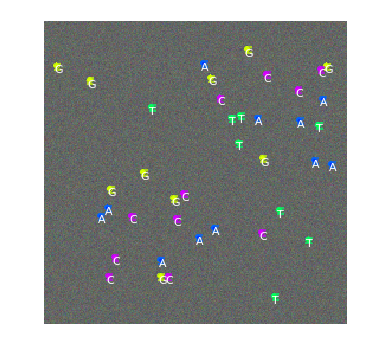

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
image_meta (17,) [  0 256 256   3 256 256   3   0   0 256 256   1   0   0   0   0   0]
(1, 17)
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16128, 4)         min:   -0.02218  max:    0.98986  float32
(1, 100, 6) (1, 160, 5) (1, 100, 28, 28, 5) (1, 1000, 4) (1, 16368, 2) (1, 16368, 4) (1, 160, 512) (1, 160)


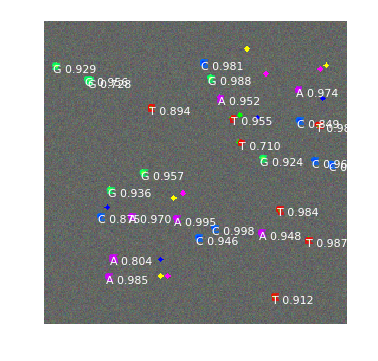

In [253]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
# image_id=33
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config1, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                             dataset_train.class_names, figsize=(12, 12))

visualize.display_instances2(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(6, 6))

gt_bbox, gt_mask, gt_class_id=gt_bbox[np.newaxis,:,:],gt_mask[np.newaxis,:,:,:], gt_class_id[np.newaxis,:]

#######
# inference_config["DETECTION_MIN_CONFIDENCE"]=0.6
results ,feats,rpn_rois,rpn_class,mrcnn_class,gt_target_class_ids=\
model.get_features([original_image],gt_bbox,gt_mask,gt_class_id,inference_config1, verbose=1)
r = results[0]
visualize.display_instances2(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], figsize=(6, 6))



In [63]:
print(detections.shape, mrcnn_class.shape, mrcnn_mask.shape, rpn_rois.shape, rpn_class.shape, rpn_bbox.shape,feats.shape,target_class_ids.shape)   




16288

In [104]:
gt_target_class_ids.shape

(1, 160)

In [71]:
print(len(r['class_ids']),len(gt_target_class_ids[0]),mrcnn_class.shape,rois.shape)

33 160 (1, 1000, 5) (1, 160, 4)


In [87]:
np.abs(rpn_match).sum()

128

0001
Loading weights from  /storage/data/marziehhaghighi/DL_trained_models/mrcnn/simul_spots/pretrained_scratch_train_heads_lr_0.001_clust/simul_spots20200812T2042/mask_rcnn_simul_spots_0001.h5
Re-starting from epoch 1
image_meta (17,) [  0 256 256   3 256 256   3   0   0 256 256   1   0   0   0   0   0]
(1, 17)
(1, 100, 6) (1, 160, 5) (1, 100, 28, 28, 5) (1, 1000, 4) (1, 16368, 2) (1, 16368, 4) (1, 160, 512) (1, 160)
(14, 2) (1, 160)


/home/marziehhaghighi/.local/lib/python3.6/site-packages/umap/umap_.py:1383: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


0002
Loading weights from  /storage/data/marziehhaghighi/DL_trained_models/mrcnn/simul_spots/pretrained_scratch_train_heads_lr_0.001_clust/simul_spots20200812T2042/mask_rcnn_simul_spots_0002.h5
Re-starting from epoch 2
image_meta (17,) [  0 256 256   3 256 256   3   0   0 256 256   1   0   0   0   0   0]
(1, 17)
(1, 100, 6) (1, 160, 5) (1, 100, 28, 28, 5) (1, 1000, 4) (1, 16368, 2) (1, 16368, 4) (1, 160, 512) (1, 160)
(36, 2) (1, 160)
0003
Loading weights from  /storage/data/marziehhaghighi/DL_trained_models/mrcnn/simul_spots/pretrained_scratch_train_heads_lr_0.001_clust/simul_spots20200812T2042/mask_rcnn_simul_spots_0003.h5
Re-starting from epoch 3
image_meta (17,) [  0 256 256   3 256 256   3   0   0 256 256   1   0   0   0   0   0]
(1, 17)
(1, 100, 6) (1, 160, 5) (1, 100, 28, 28, 5) (1, 1000, 4) (1, 16368, 2) (1, 16368, 4) (1, 160, 512) (1, 160)
(52, 2) (1, 160)
0004
Loading weights from  /storage/data/marziehhaghighi/DL_trained_models/mrcnn/simul_spots/pretrained_scratch_train_head

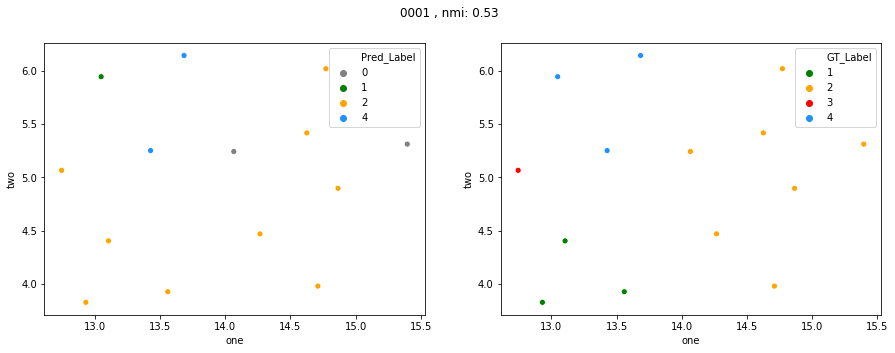

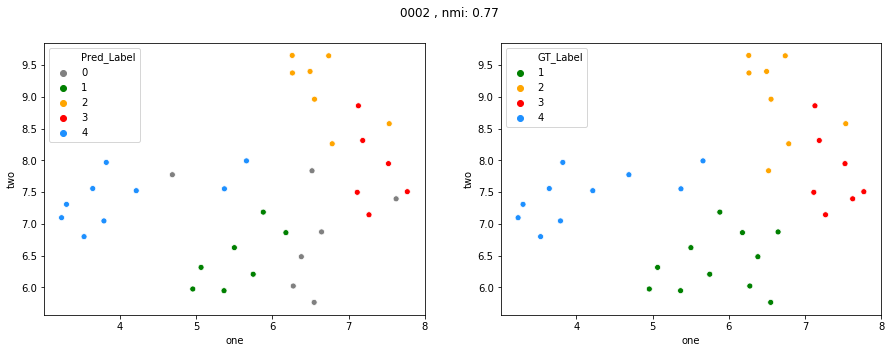

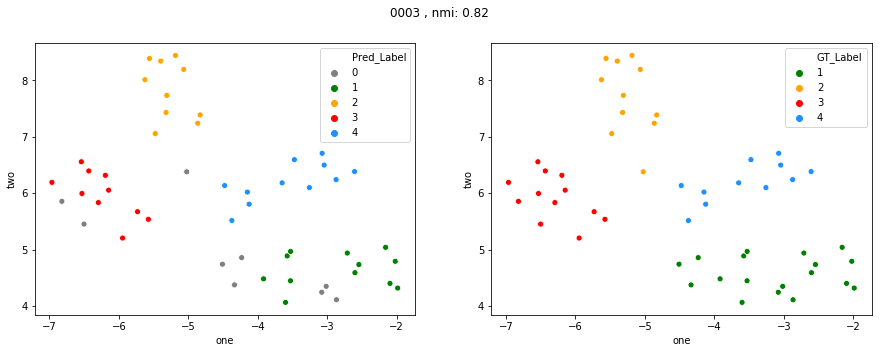

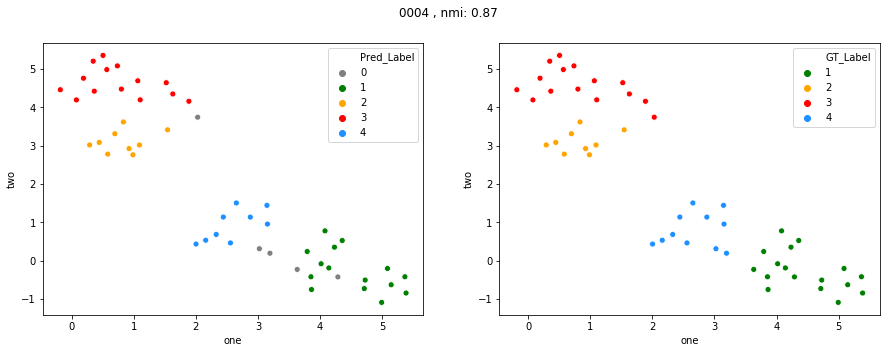

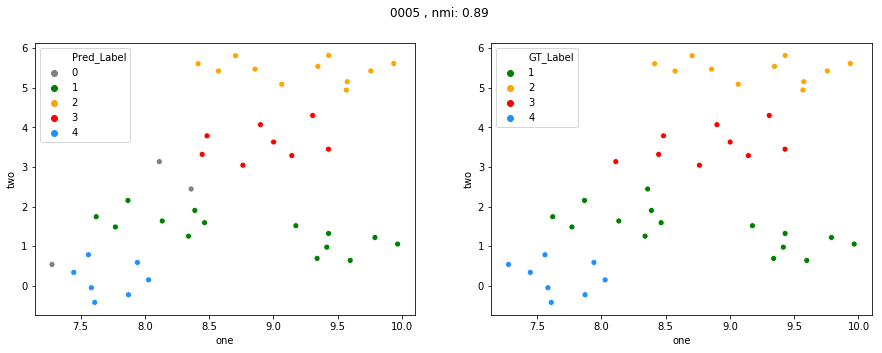

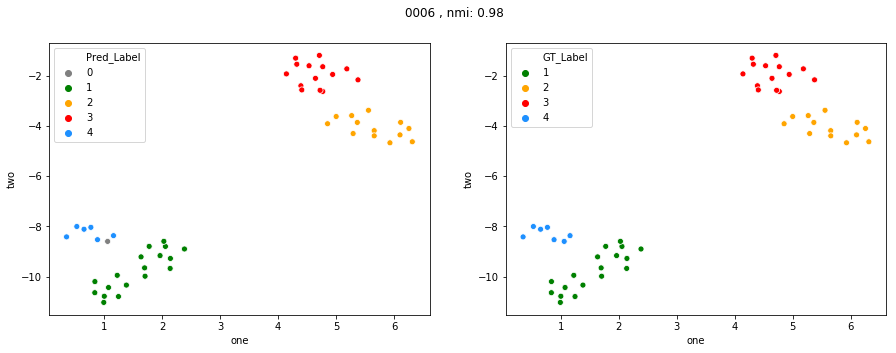

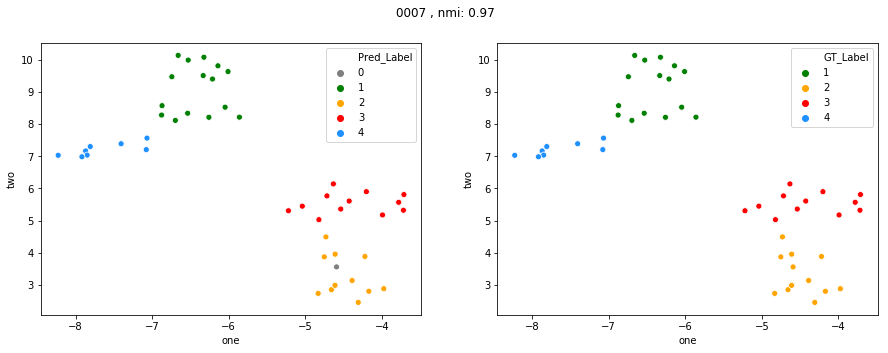

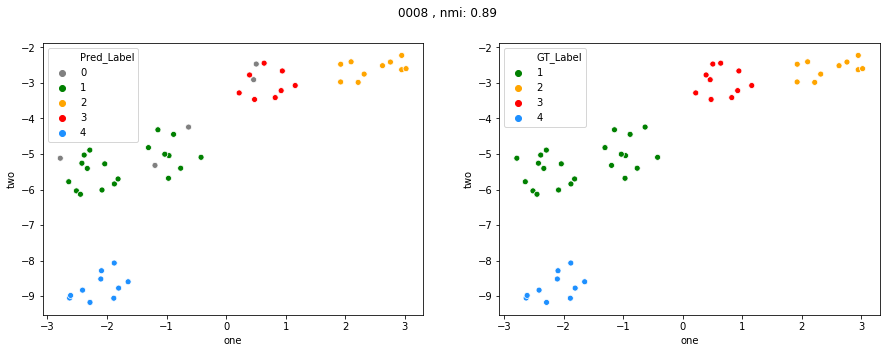

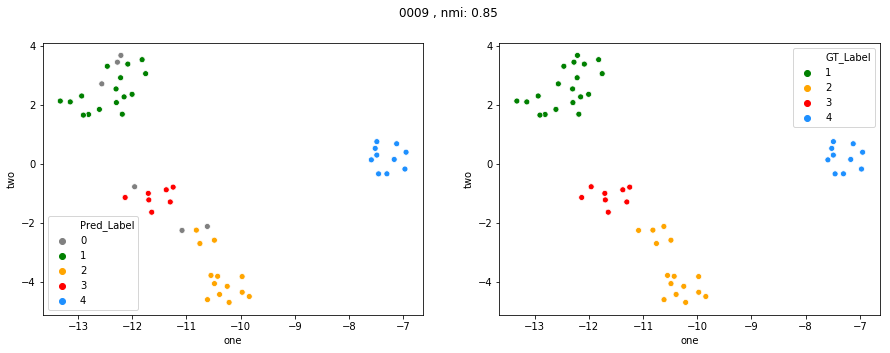

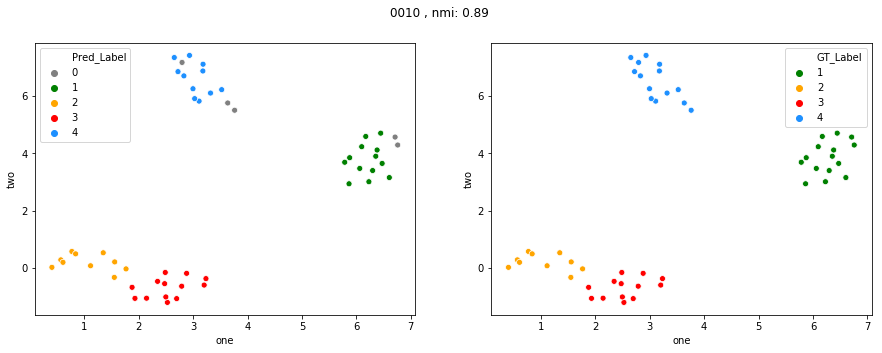

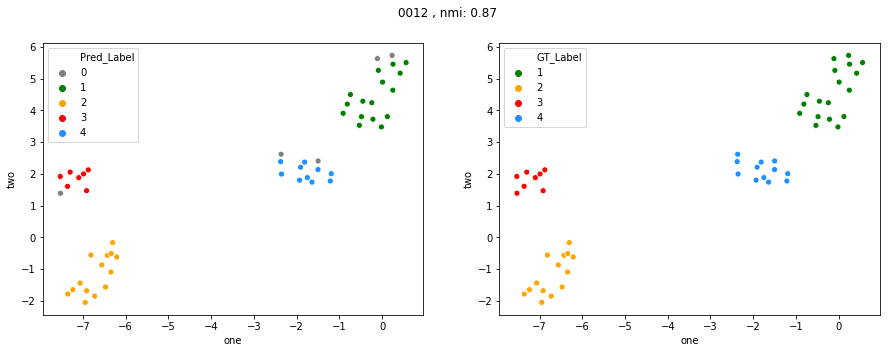

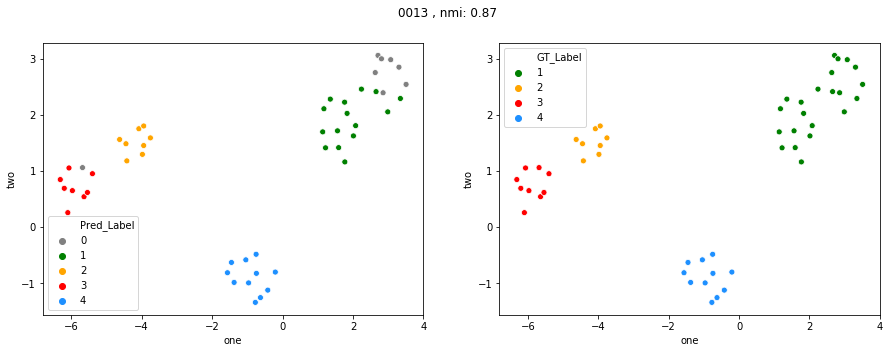

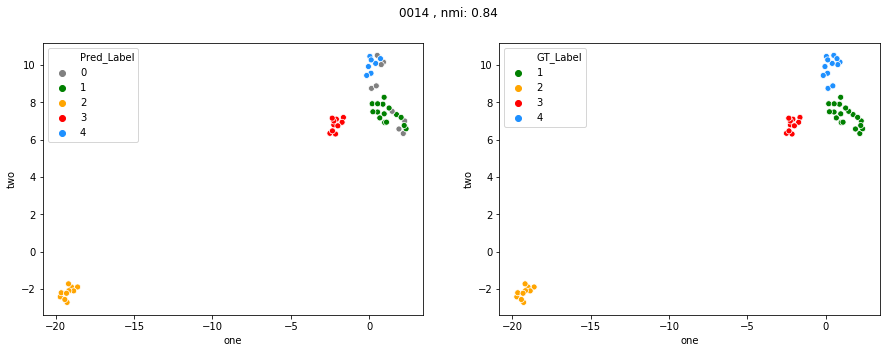

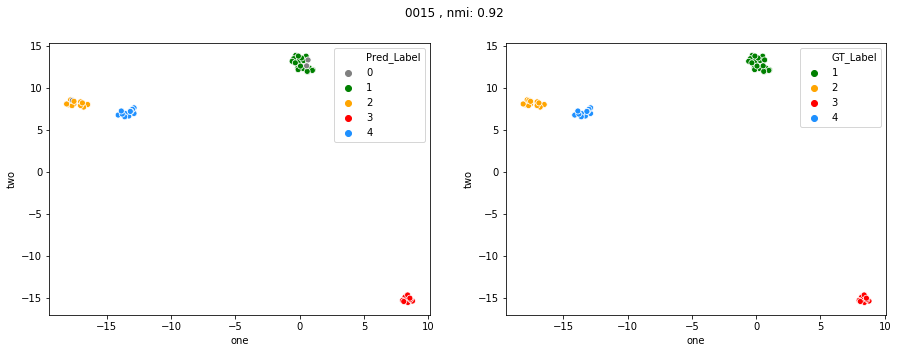

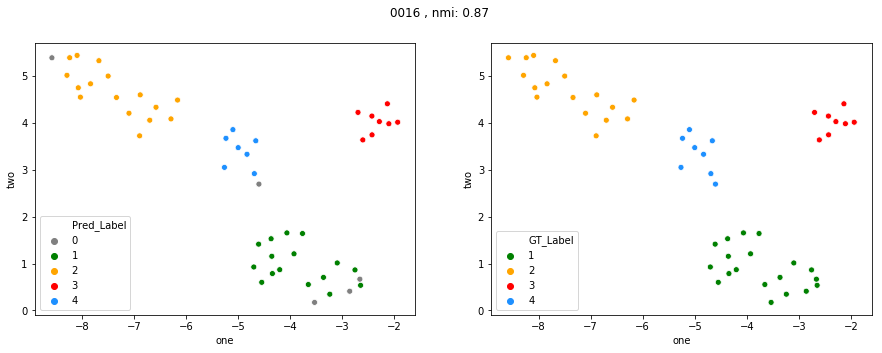

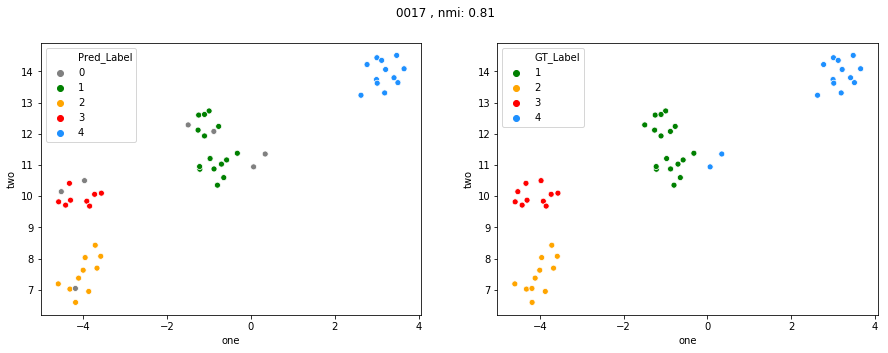

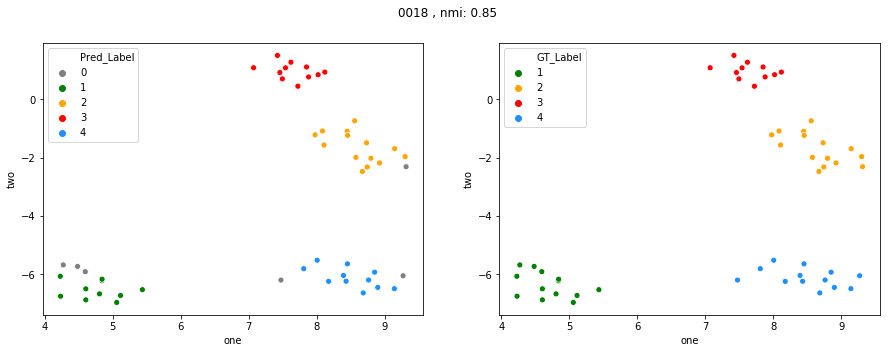

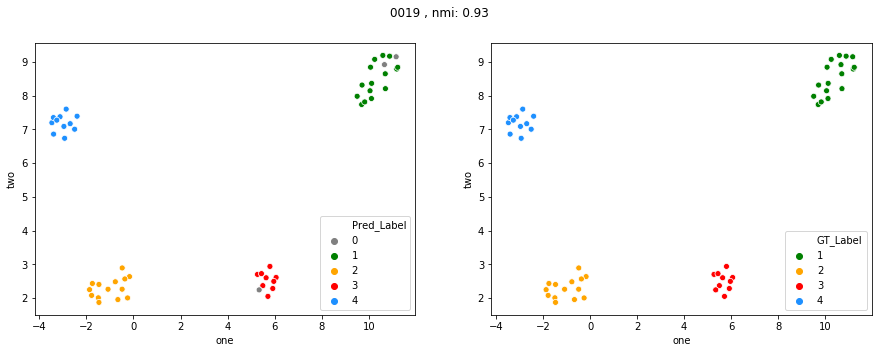

In [224]:
for e in range(1,20):
#     epoch='0002'
    epoch=str(e).zfill(4)
    print(epoch)
    # image_id=33
    ax=umap_on_feats(image_id,epoch)

0001
Loading weights from  /storage/data/marziehhaghighi/DL_trained_models/mrcnn/simul_spots/pretrained_scratch_train_heads_lr_0.001_clust/simul_spots20200812T2042/mask_rcnn_simul_spots_0001.h5
Re-starting from epoch 1
image_meta (17,) [  0 256 256   3 256 256   3   0   0 256 256   1   0   0   0   0   0]
(1, 17)
(1, 100, 6) (1, 160, 5) (1, 100, 28, 28, 5) (1, 1000, 4) (1, 16368, 2) (1, 16368, 4) (1, 160, 512) (1, 160)
(12, 2) (1, 160)


/home/marziehhaghighi/.local/lib/python3.6/site-packages/umap/umap_.py:1383: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


0002
Loading weights from  /storage/data/marziehhaghighi/DL_trained_models/mrcnn/simul_spots/pretrained_scratch_train_heads_lr_0.001_clust/simul_spots20200812T2042/mask_rcnn_simul_spots_0002.h5
Re-starting from epoch 2
image_meta (17,) [  0 256 256   3 256 256   3   0   0 256 256   1   0   0   0   0   0]
(1, 17)
(1, 100, 6) (1, 160, 5) (1, 100, 28, 28, 5) (1, 1000, 4) (1, 16368, 2) (1, 16368, 4) (1, 160, 512) (1, 160)
(43, 2) (1, 160)
0003
Loading weights from  /storage/data/marziehhaghighi/DL_trained_models/mrcnn/simul_spots/pretrained_scratch_train_heads_lr_0.001_clust/simul_spots20200812T2042/mask_rcnn_simul_spots_0003.h5
Re-starting from epoch 3
image_meta (17,) [  0 256 256   3 256 256   3   0   0 256 256   1   0   0   0   0   0]
(1, 17)
(1, 100, 6) (1, 160, 5) (1, 100, 28, 28, 5) (1, 1000, 4) (1, 16368, 2) (1, 16368, 4) (1, 160, 512) (1, 160)
(52, 2) (1, 160)
0004
Loading weights from  /storage/data/marziehhaghighi/DL_trained_models/mrcnn/simul_spots/pretrained_scratch_train_head

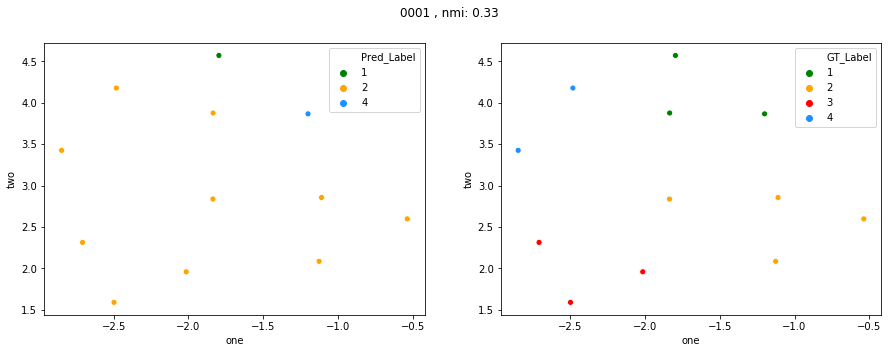

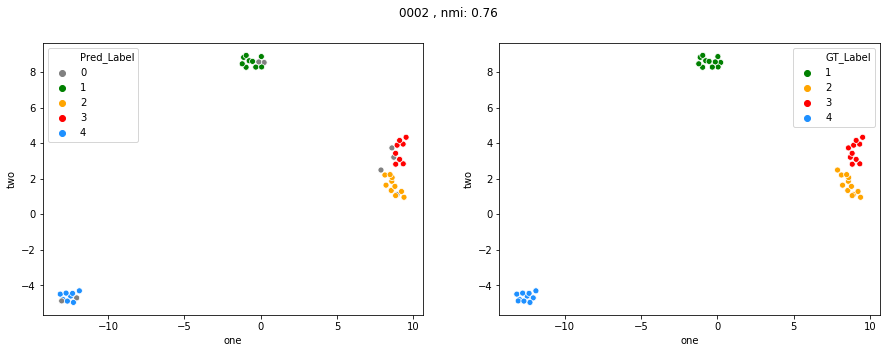

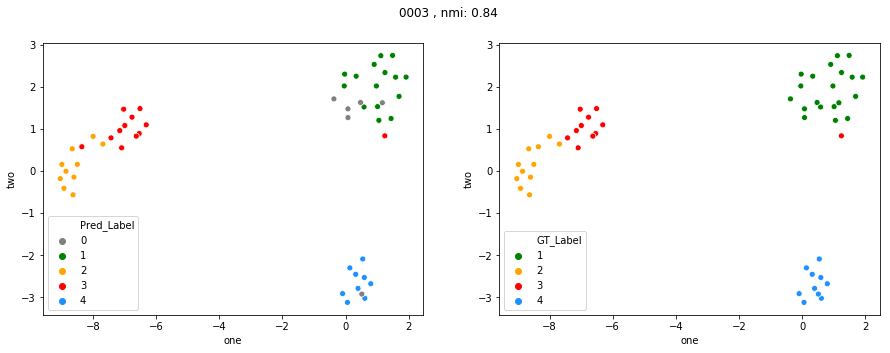

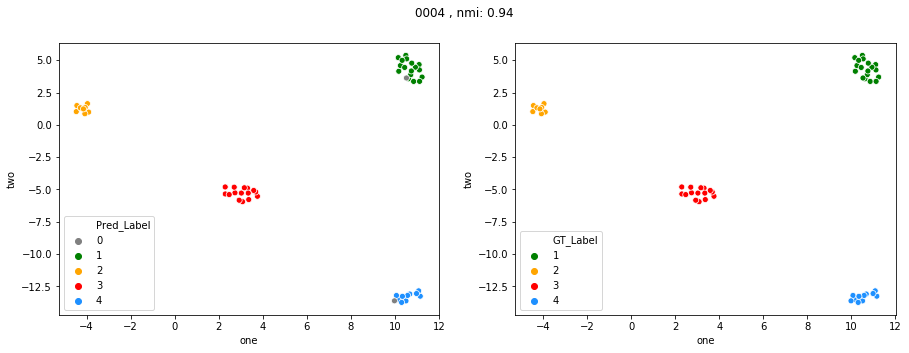

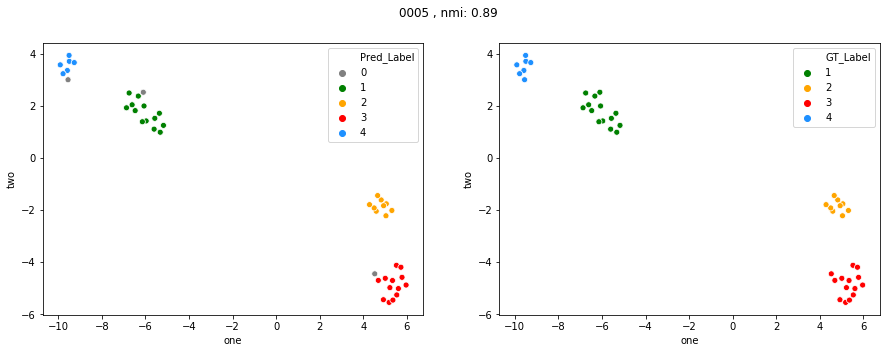

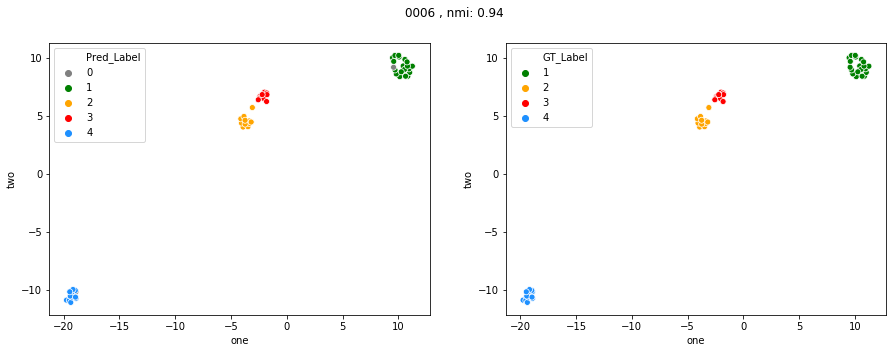

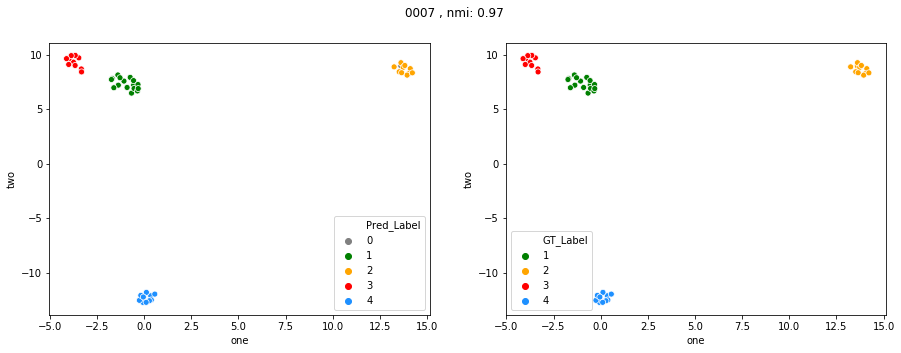

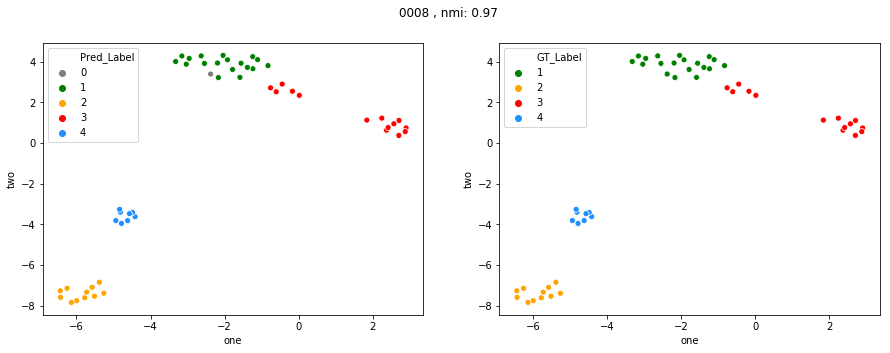

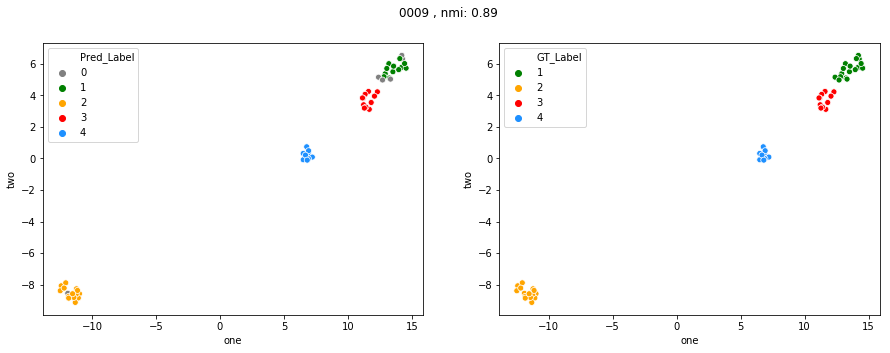

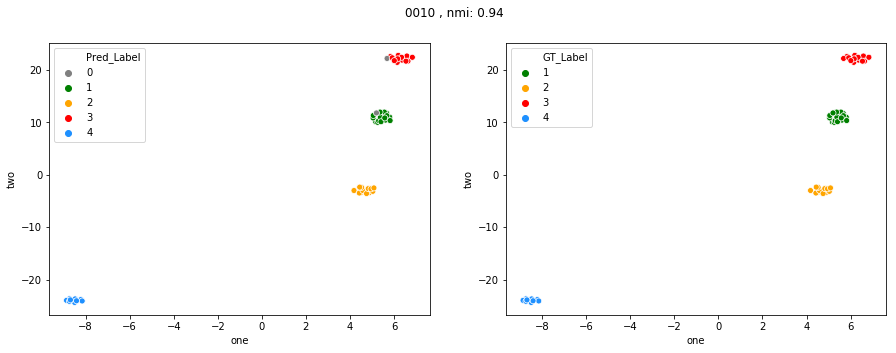

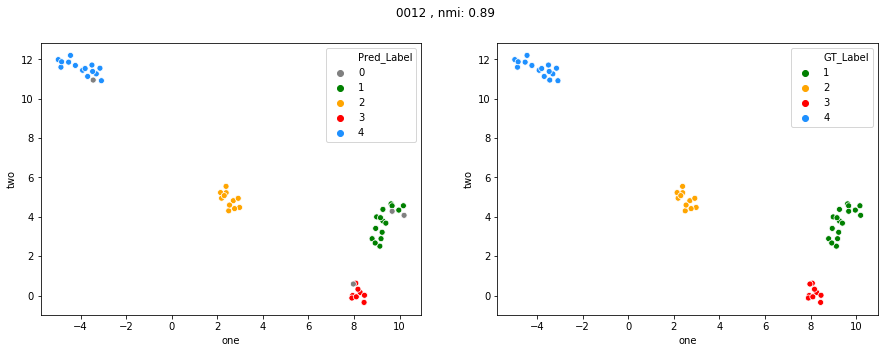

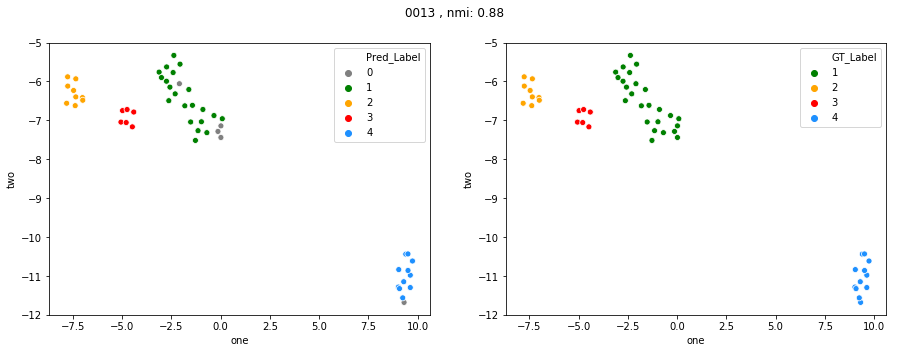

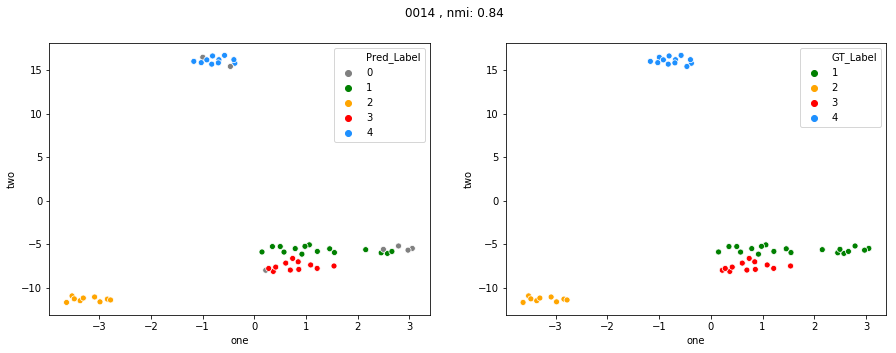

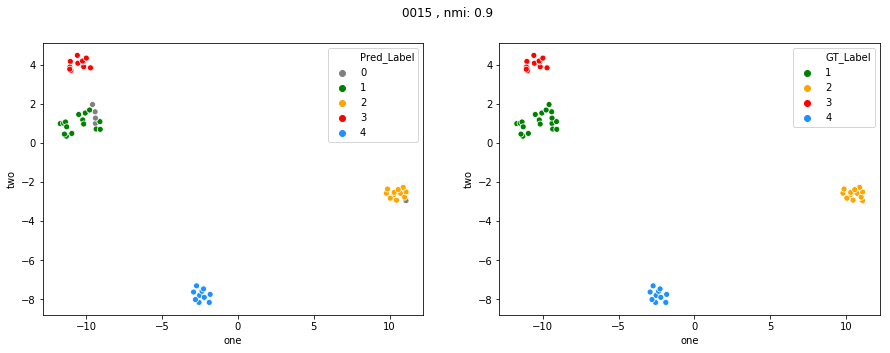

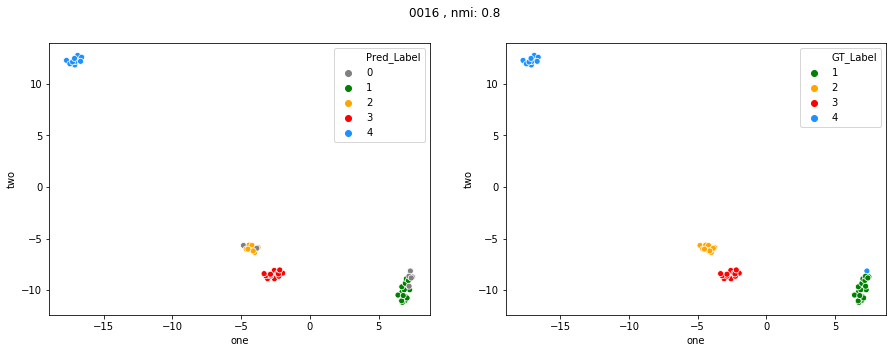

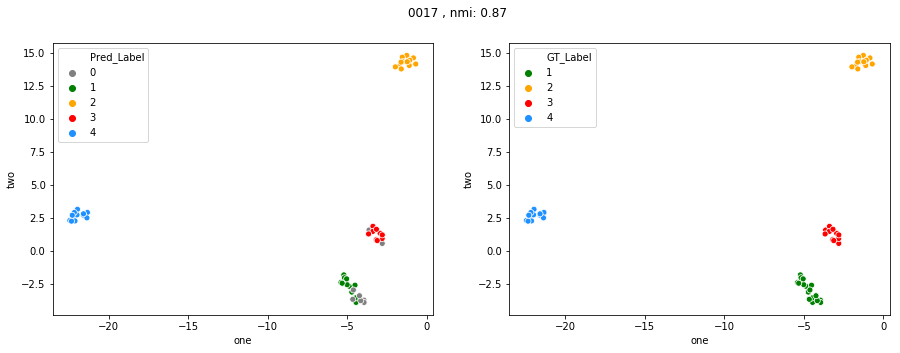

In [220]:
# Test on a random image
# image_id = random.choice(dataset_val.image_ids)
for e in range(1,18):
#     epoch='0002'
    epoch=str(e).zfill(4)
    print(epoch)
    # image_id=33
    ax=umap_on_feats(image_id,epoch)

In [53]:
mid_layer

<tf.Tensor 'mrcnn_class_logits_5/Reshape_1:0' shape=(?, 1000, 5) dtype=float32>

In [54]:
mid_layer = model.keras_model.get_layer("mrcnn_class_logits")

In [65]:
def sklearn_kmeans_foreground(X,pred_class_ids,gt_ids,nClust):
    from sklearn.cluster import KMeans
    from sklearn import preprocessing
    from sklearn.decomposition import PCA    
    #     inputs
    # X              (n_batches, n_samples_perbacth, n_features)
    # feat_arr       (n_samples, n_features)
    # gt_ids         (n_batches, n_samples_perbacth)
    # pred_class_ids (n_batches, n_samples_perbacth)
    #
    #     Output
    # psudo_labels_based_on_clustering
    
    
#     nClust=5
    n_samples=X.shape[0]*X.shape[1]
    n_feats=X.shape[2]
#     print("gt_ids",gt_ids)
    gt_ids_vec=gt_ids.flatten()
    feat_arr = X.reshape(n_samples,n_feats)
    pred_class_ids=pred_class_ids+1
    pred_labels_arr = pred_class_ids.flatten()
#         print("pred_labels_arr",pred_labels_arr)

    if 1:
        pca = PCA(n_components=64, whiten=True)
        x_pca=pca.fit_transform(feat_arr)
        norm = np.linalg.norm(x_pca, axis=1)
        feat_arr = x_pca / norm[:, np.newaxis]


    psudo_labels_based_on_clustering=np.zeros(n_samples)
    forg_index=np.where(gt_ids_vec!=0)[0]
    feat_arr_forg=feat_arr[forg_index,:]
#     print("forg_index",forg_index,feat_arr_forg.shape)
    
    pred_labels_arr_cents=calculate_cluster_centroids(feat_arr_forg,pred_labels_arr[forg_index],nClust)
    
    y = np.bincount(pred_labels_arr[forg_index])
    ii = np.nonzero(y)[0]
    print("True Labels: ",np.vstack((ii,y[ii])).T)
    
    
    if len(forg_index)>nClust:
        kmeans = KMeans(n_clusters=nClust-1, random_state=0).fit(feat_arr_forg)
        
#         kmeans = KMeans(n_clusters=nClust-1,init=np.nan_to_num(pred_labels_arr_cents[1:,:])).fit(feat_arr_forg)
        psudo_labels_based_on_clustering[forg_index]=kmeans.labels_+1
    else:
        psudo_labels_based_on_clustering[forg_index]=pred_labels_arr[forg_index]
        
        
    if len(forg_index)>nClust:
#         reassigned_labels=reas_labels2(psudo_labels_based_on_clustering[forg_index],\
#                                        pred_labels_arr[forg_index])

# #         reassigned_labels=reas_labels3(kmeans.labels_,\
# #                                        pred_labels_arr[forg_index],kmeans.cluster_centers_,feat_arr_forg,nClust-1)
        reassigned_labels=reas_labels3(kmeans.labels_,\
                                       pred_labels_arr_cents,kmeans.cluster_centers_,feat_arr_forg,nClust-1)

#         reassigned_labels=kmeans.labels_+1
# (clustering_labels,kmeans_centers,X)
        psudo_labels_based_on_clustering[forg_index]=reassigned_labels
    
    y = np.bincount(psudo_labels_based_on_clustering[forg_index].astype('int64'))
    ii = np.nonzero(y)[0]
    print("psudo labels: ",np.vstack((ii,y[ii])).T)
    
    
    psudo_labels_based_on_clustering_reshaped=psudo_labels_based_on_clustering.\
    reshape(X.shape[0],X.shape[1]).astype('int32')
    
#     print("psudo_labels_based_on_clustering_reshaped",psudo_labels_based_on_clustering_reshaped)
#     print("nmi: ",utils.NMI_clus_class(psudo_labels_based_on_clustering[forg_index],gt_ids_vec[forg_index]))
    return psudo_labels_based_on_clustering_reshaped

array([1, 1, 4, 1, 2, 1, 2, 2, 1, 2, 4], dtype=int32)

In [223]:
def umap_on_feats(image_id,epoch):

    model_path = MODEL_DIR+"/mask_rcnn_"+inference_config1.NAME+'_'+epoch+".h5"
    # Load trained weights
    if os.path.isfile(model_path):
        print("Loading weights from ", model_path)
        model.load_weights(model_path, by_name=True)

        original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_val, inference_config1, 
                                   image_id, use_mini_mask=False)

        gt_bbox, gt_mask, gt_class_id=gt_bbox[np.newaxis,:,:],gt_mask[np.newaxis,:,:,:], gt_class_id[np.newaxis,:]

        #######
        results ,feats,rpn_rois,rpn_class,mrcnn_class,gt_target_class_ids=\
        model.get_features([original_image],gt_bbox,gt_mask,gt_class_id,inference_config1, verbose=0)
        ####################
        from sklearn import preprocessing
        from sklearn.metrics.cluster import normalized_mutual_info_score
        from sklearn.decomposition import PCA    
        import umap
        umapT=umap.UMAP()
        import pandas as pd 
        import seaborn as sns

        raw_feats=np.squeeze(feats)

        classes=np.squeeze(np.argmax(mrcnn_class,axis=2))
    #         forg_index=np.where(classes!=0)[0]
        forg_index=np.where(gt_target_class_ids!=0)[1]
    #         forg_index=np.array(range(len(classes)))

        if 0:
            pca = PCA(n_components=64, whiten=True)
            x_pca=pca.fit_transform(raw_feats)
            norm = np.linalg.norm(x_pca, axis=1)
            raw_feats = x_pca / norm[:, np.newaxis]

        feats_forg=raw_feats[forg_index,:];
        pred_label=classes[forg_index]
        gt_label=gt_target_class_ids[0,forg_index]

        feat_arr=np.copy(feats_forg)

        if 0:
            pca = PCA(n_components=64, whiten=True)
            x_pca=pca.fit_transform(feat_arr)
            norm = np.linalg.norm(x_pca, axis=1)
            feat_arr = x_pca / norm[:, np.newaxis]


        Y = umapT.fit_transform(feat_arr)
        #     Y = tsneT.fit_transform(preprocData)
        tsneResDF=pd.DataFrame(index=range(Y.shape[0]),columns=['one','two','Pred_Label','GT_Label']);
        print(Y.shape,gt_target_class_ids.shape)
        tsneResDF.loc[:,['one','two']]=Y
        tsneResDF.loc[:,'Pred_Label']=pred_label
        tsneResDF.loc[:,'GT_Label']=gt_label



        if 1:
            nClust=5
            pred_labels_arr_cents=utils.calculate_cluster_centroids(feats_forg,pred_label,nClust)
            gt_labels_arr_cents=utils.calculate_cluster_centroids(feats_forg,gt_label-1,nClust-1)
    #         reassigned_labels=utils.reas_labels3(pred_label,\
    #                                            gt_labels_arr_cents,pred_labels_arr_cents,feats_forg,nClust-1)
            reassigned_labels=utils.reas_labels3(gt_label-1,\
                                               pred_labels_arr_cents,gt_labels_arr_cents,feats_forg,nClust-1)
            tsneResDF.loc[:,'GT_Label']=reassigned_labels

        nmi=normalized_mutual_info_score(tsneResDF['Pred_Label'].values,tsneResDF['GT_Label'].values)


        palette_dict={0:'grey',1:'green',2:'orange',3:'red',4:'dodgerblue'}


        f, axes = plt.subplots(1,2, figsize=(15,5))
        f.suptitle(epoch+' , nmi: '+str(np.round(nmi,2)))

        sns.scatterplot(x="one", y="two", hue="Pred_Label",data=tsneResDF,palette=palette_dict,ax=axes[0])
        sns.scatterplot(x="one", y="two", hue="GT_Label",data=tsneResDF,palette=palette_dict,ax=axes[1])
    return 

Loading weights from  /storage/data/marziehhaghighi/DL_trained_models/mrcnn/simul_spots/pretrained_scratch_train_all_lr_0.001_clust/simul_spots20200810T1736/mask_rcnn_simul_spots_0019.h5
Re-starting from epoch 19
image_meta (17,) [  0 256 256   3 256 256   3   0   0 256 256   1   0   0   0   0   0]
(1, 17)
(1, 100, 6) (1, 160, 5) (1, 100, 28, 28, 5) (1, 1000, 4) (1, 16368, 2) (1, 16368, 4) (1, 160, 512) (1, 160)
(52, 2) (1, 160)
[0 3 0 0 1 2 2 3 1 1 0 1 3 2 3 2 2 2 0 3 1 1 3 1 1 2 2 2 3 1 2 0 0 0 0 2 0
 2 1 0 3 1 0 2 2 1 3 1 1 2 1 2]


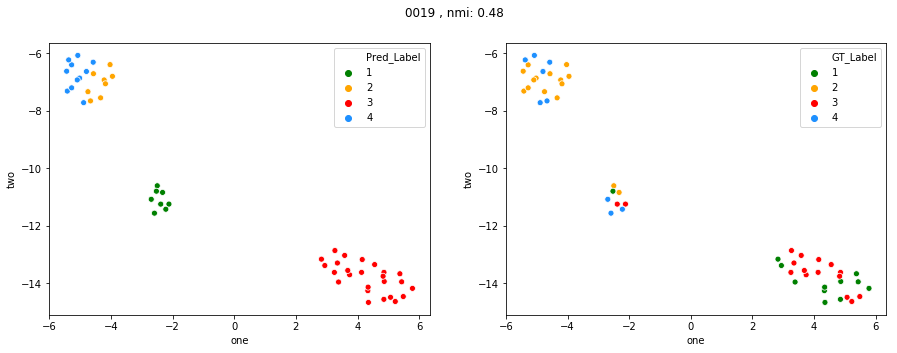

In [192]:
model_path = MODEL_DIR+"/mask_rcnn_"+inference_config1.NAME+'_'+epoch+".h5"
# Load trained weights
if os.path.isfile(model_path):
    print("Loading weights from ", model_path)
    model.load_weights(model_path, by_name=True)

    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config1, 
                               image_id, use_mini_mask=False)

    gt_bbox, gt_mask, gt_class_id=gt_bbox[np.newaxis,:,:],gt_mask[np.newaxis,:,:,:], gt_class_id[np.newaxis,:]

    #######
    results ,feats,rpn_rois,rpn_class,mrcnn_class,gt_target_class_ids=\
    model.get_features([original_image],gt_bbox,gt_mask,gt_class_id,inference_config1, verbose=0)
    ####################
    from sklearn import preprocessing
    from sklearn.metrics.cluster import normalized_mutual_info_score
    from sklearn.decomposition import PCA    
    import umap
    umapT=umap.UMAP()
    import pandas as pd 
    import seaborn as sns

    raw_feats=np.squeeze(feats)

    classes=np.squeeze(np.argmax(mrcnn_class,axis=2))
#         forg_index=np.where(classes!=0)[0]
    forg_index=np.where(gt_target_class_ids!=0)[1]
#         forg_index=np.array(range(len(classes)))

    if 0:
        pca = PCA(n_components=64, whiten=True)
        x_pca=pca.fit_transform(raw_feats)
        norm = np.linalg.norm(x_pca, axis=1)
        raw_feats = x_pca / norm[:, np.newaxis]

    feats_forg=raw_feats[forg_index,:];
    pred_label=classes[forg_index]
    gt_label=gt_target_class_ids[0,forg_index]
    
    feat_arr=np.copy(feats_forg)

    if 0:
        pca = PCA(n_components=16, whiten=True)
        x_pca=pca.fit_transform(feat_arr)
        norm = np.linalg.norm(x_pca, axis=1)
        feat_arr = x_pca / norm[:, np.newaxis]


    Y = umapT.fit_transform(feat_arr)
    #     Y = tsneT.fit_transform(preprocData)
    tsneResDF=pd.DataFrame(index=range(Y.shape[0]),columns=['one','two','Pred_Label','GT_Label']);
    print(Y.shape,gt_target_class_ids.shape)
    tsneResDF.loc[:,['one','two']]=Y
    tsneResDF.loc[:,'Pred_Label']=pred_label
    tsneResDF.loc[:,'GT_Label']=gt_label


    
    if 1:
        nClust=5
        pred_labels_arr_cents=utils.calculate_cluster_centroids(feats_forg,pred_label,nClust)
        gt_labels_arr_cents=utils.calculate_cluster_centroids(feats_forg,gt_label-1,nClust-1)
#         reassigned_labels=utils.reas_labels3(pred_label,\
#                                            gt_labels_arr_cents,pred_labels_arr_cents,feats_forg,nClust-1)
        reassigned_labels=utils.reas_labels3(gt_label-1,\
                                           pred_labels_arr_cents,gt_labels_arr_cents,feats_forg,nClust-1)
        tsneResDF.loc[:,'GT_Label']=reassigned_labels
    
    nmi=normalized_mutual_info_score(tsneResDF['Pred_Label'].values,tsneResDF['GT_Label'].values)


    palette_dict={0:'grey',1:'green',2:'orange',3:'red',4:'dodgerblue'}


    f, axes = plt.subplots(1,2, figsize=(15,5))
    f.suptitle(epoch+' , nmi: '+str(np.round(nmi,2)))

    sns.scatterplot(x="one", y="two", hue="Pred_Label",data=tsneResDF,palette=palette_dict,ax=axes[0])
    sns.scatterplot(x="one", y="two", hue="GT_Label",data=tsneResDF,palette=palette_dict,ax=axes[1])


In [184]:
pred_label,gt_labels_arr_cents,pred_labels_arr_cents,feats_forg

(array([3, 4, 3, 3, 2, 2, 2, 4, 3, 1, 4, 4, 1, 4, 3, 3, 4, 3, 1, 3, 2, 3,
        3, 1, 2, 3, 2, 1, 1, 3, 3, 4, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3,
        1, 4, 3, 3, 3, 3, 4, 4]),
 array([[       nan,        nan,        nan, ...,        nan,        nan,
                nan],
        [0.        , 0.0243384 , 0.        , ..., 0.04460955, 0.02204891,
         0.06362104],
        [0.22428775, 0.05308377, 0.        , ..., 0.02524939, 0.        ,
         0.471935  ],
        [0.20020114, 0.        , 0.        , ..., 0.37269476, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.00594344, 0.        ,
         0.03642079]]),
 array([[       nan,        nan,        nan, ...,        nan,        nan,
                nan],
        [0.10623457, 0.11692736, 0.        , ..., 0.02189054, 0.        ,
         0.81726319],
        [0.28917944, 0.        , 0.        , ..., 0.54656029, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ...

In [190]:
gt_labels_arr_cents.shape

(4, 512)

In [165]:
gt_target_class_ids

array([[4, 3, 3, 2, 2, 1, 1, 1, 3, 3, 1, 1, 4, 2, 4, 3, 3, 4, 3, 4, 1, 4,
        1, 1, 1, 2, 2, 4, 2, 4, 3, 2, 2, 4, 1, 3, 2, 2, 1, 4, 4, 1, 4, 1,
        4, 3, 3, 2, 4, 4, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]], dtype=int32)

In [169]:
classes

array([3, 2, 4, 4, 1, 3, 3, 3, 2, 2, 3, 3, 3, 4, 3, 2, 4, 3, 2, 3, 3, 3,
       3, 3, 3, 2, 1, 3, 4, 3, 2, 2, 1, 3, 3, 4, 4, 4, 3, 3, 3, 1, 3, 3,
       3, 4, 1, 4, 3, 3, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [167]:
pred_label

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3])

In [168]:
classes[forg_index]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3])

In [172]:
forg_index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51])